# A Bag-of-Words approach applied to image description

                                                         Valentyn G, Léane S

## Importing data and libraries

Preparatory actions.


In [ ]:
# Loading the dataset
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
!unzip TP1-2-data.zip

# Loading the toolset 
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2/tools.py

In [2]:
# Python libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
%run 'tools.py'

In [4]:
# Save path settings
import os
from os.path import join
data_path = "data"
save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# Setting the size of the dev set.
max_images_per_class = 100  # You can change this to None to compute the whole dataset (takes quite some time)
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)

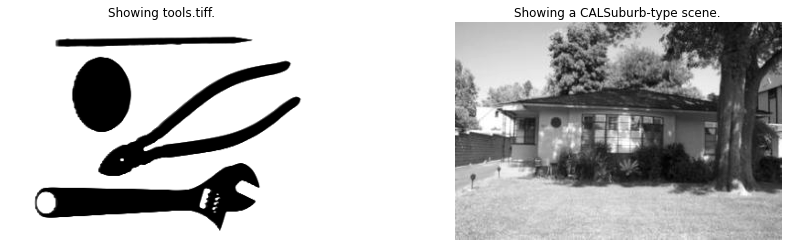

In [6]:
# Showing two example images from the database.
I = read_grayscale(join(data_path,'tools.tiff'))
I2 = read_grayscale(join(data_path,'Scene/CALsuburb/image_0205.jpg'))
fig = plt.figure(figsize = (15,4))
ax1 = fig.add_subplot(121)
ax1.set_title('Showing tools.tiff.')
plt.imshow(I,cmap='gray')
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.set_title('Showing a CALSuburb-type scene.')
plt.imshow(I2,cmap='gray')
plt.axis('off')
plt.show()

## Applying SIFT decomposition

SIFT (Scale Invariant Feature Transform) is a technique used to map images onto finite sets of descriptors (chosen feature vectors) - along which we may compute similarities and find areas of interest. Two pictures of the same object should have close descriptors. The variation in feature vectors would be bigger for pictures showing different objects in different settings.  
This is the first step towards computing a Bag-of-Words representation for a full dataset.  
For a given task, storing a SIFT-ed database instead of the original images also helps reduce the size of the data we use.



### Basic gradient computations

The SIFT technique first relies on computing the gradient orientation and norm using classical horizontal and vertical edge detectors.

In [7]:
# Computing the gradient by means of a double convolution.
def compute_grad(I):
    #####################
    ## Votre code ici  ##
    #####################
    # The given filters are separable.
    sep1 = 0.5*np.array([-1,0,1])
    sep2 = 0.5*np.array([1,2,1])
    # This property makes the computation easier.
    Ix = conv_separable(I,sep1,sep2)
    Iy = conv_separable(I,sep2,sep1)
    ####################
    ##      FIN        #
    ####################
    return Ix, Iy

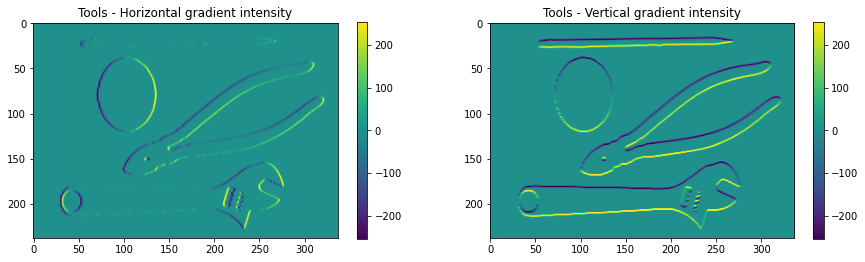

In [8]:
# Showing results.
Ix,Iy = compute_grad(I)
grads = plt.figure(figsize=(15,4))
# Subplot 1
ax1 = grads.add_subplot(121)
ax1.set_title('Tools - Horizontal gradient intensity')
plt.imshow(Ix)
plt.colorbar()
# Subplot 2
ax2 = grads.add_subplot(122)
ax2.set_title('Tools - Vertical gradient intensity')
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [9]:
# Computing the gradient's module and orientation.
def compute_grad_mod_ori(I):
    #####################
    ## Votre code ici  ##
    #####################
    Ix,Iy = compute_grad(I)
    # Gradient norm.
    Gn = np.sqrt(Ix**2+Iy**2)
    # Gradient orientation.
    Go = compute_grad_ori(Ix,Iy,Gn)
    ####################
    ##      FIN        #
    ####################
    return Gn, Go

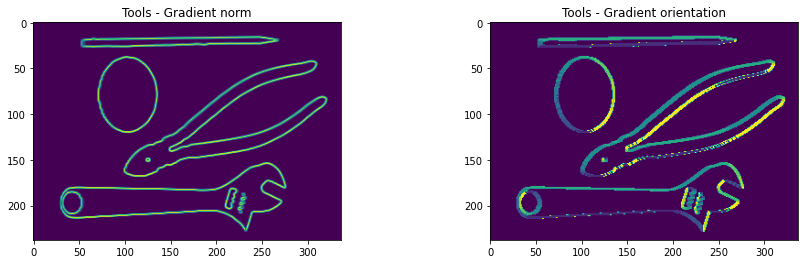

In [10]:
# Showing results.
Gn, Go = compute_grad_mod_ori(I)
grads = plt.figure(figsize=(15,4))
# Subplot 1.
ax1 = grads.add_subplot(121)
ax1.set_title('Tools - Gradient norm')
plt.imshow(Gn)
# Subplot 2
ax2 = grads.add_subplot(122)
ax2.set_title('Tools - Gradient orientation')
plt.imshow(Go)
plt.show()

### Generating SIFT descriptors

We then apply the SIFT computation to a mesh of overlapping square regions for each image found in the database.

In [11]:
# Making histograms out of the grd. orientiation values.
def compute_histogram(g_n, g_o):
    # g_n and g_o are 4x4 matrices that contain the gradient's norms and discrete orientations.
    # Warning: g_o can be -1 when undefined, and those values must be discarded.
    hist = np.zeros((8))
    #####################
    ## Votre code ici  ##
    #####################
    # g_n and g_o have the same shape.
    for i in range(g_n.shape[1]):
        for j in range(g_n.shape[1]):
            # Put a condition to discard unsettled/irrelevant orientations.
            if g_o[i][j] != -1:
                # Build the histogram as per the distribution of orientation values.
                hist[g_o[i][j]] += g_n[i][j]                                    
    ####################
    ##      FIN        #
    ####################
    return hist

In [12]:
# Applying the SIFT computation to one region.
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    # misleading names since t_min and t_max are applied to different processing stages))
    with_l2 = True
    patch_size = 16
    sift = np.zeros((128)) 
    # Applying a Gaussian mask (NOT A FILTER)
    if mask is not None:
        Gn = Gn * mask
    # Retrieving the gradient orientations found in the patch.
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8
    norm = np.linalg.norm(sift, ord=2)
    # Thresholding on the descriptor's norm : discard as irrelevant if too small
    if norm <= t_min:
        return np.zeros((128))
    # Apply L2-normalisation
    if with_l2:
        sift = sift / norm
    # Max thresholding on normalised histogram values
    sift[sift >= t_max] = t_max
    # Last normalisation
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

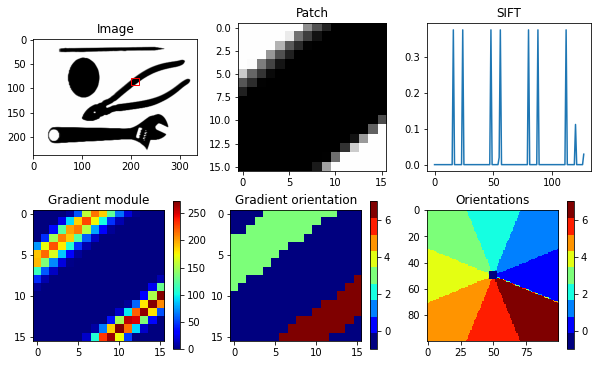

In [13]:
# Visualising SIFTs. Set gausm to True to apply mask weighting of gradients.
oneimage = display_sift_region(I,         compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=True)
# display_sift_region(marche_im(),        compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=True)
# display_sift_region(marche_im(),        compute_grad_mod_ori, compute_sift_region, x=100, y=115, gausm=True)
# display_sift_region(marche_im(),        compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=True)
# display_sift_region(marche_im(),        compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=True)
# amask = display_sift_region(toy_im(),   compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=True)
# nomask = display_sift_region(toy_im(),  compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

# A Gaussian mask would reduce the weight of some "secondary" orientations in the SIFT descriptor (from 0.25 > totalsum > 0.20 to totalsum < 0.20).
# Those images are way too simple to really show the advantages though.

In [14]:
# Generalising the computation to a complete image.
def compute_sift_image(I):
    # dense_sampling() selects a bunch of squares from an image (with a step of 8 pixels)
    # and returns their upper left corners.
    x,y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()
    #####################
    ## Votre code ici  ##
    #####################
    # Computing the gradient's norm and orientation on the whole image.
    Gn, Go = compute_grad_mod_ori(im)
    ####################
    ##      FIN        #
    ####################
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #####################
            ## Votre code ici  ##
            #####################
            # Applying the SIFT computation to each selected 16*16 region.
            sifts[i,j,:] = compute_sift_region(Gn[xi:xi+16,yj:yj+16],Go[xi:xi+16,yj:yj+16],mask=m)
            ####################
            ##      FIN        #
            ####################
    return sifts

### Computing the full dataset's SIFTs

Wrapping it all up. This is a time-consuming computation.
The result gets saved at the first execution.

In [15]:
dir_sift = os.path.join(save_path, 'sift')
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

## Making a visual dictionary

A visual dictionary represents a clustered SIFT set.  
The cluster centers should correspond to distinct textures and visual details that are sampled from their elements.


### The making-of

In [16]:
# Making a visual dictionary out of the SIFT-ed data.
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # Reorder data.
    dim_sift = sift[0].shape[-1]
    # This array has as many rows as there are pictures in the database.
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # Remove zero vectors (some images might get null SIFTs).
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # Randomly pick some SIFTS (pc = 5% of them)
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    #####################
    ## Votre code ici  ##
    #####################
    # Applying KMeans clustering to the SIFTs we kept.
    km = KMeans(n_clusters=n_clusters,n_init=n_init,verbose=0)
    km.fit(sift)
    # Getting the cluster centers values. Trying to get the dimensions right : 
    # there are 1000 of them, - n_clusters as chosen, and each has 128 columns. 
    # Remember that each SIFT is initially associated with an image as a row number, and has 128 features.
    centroides = km.cluster_centers_
    # Building the dictionary, just adding a zero cluster.
    zeros = np.zeros((1,dim_sift))
    vdict = np.vstack((centroides,zeros))
    ####################
    ##      FIN        #
    ####################
    return vdict

In [17]:
# Running the visual dictionary computation 
# (saved whenever the folder is not found)
path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict
Computing or loading SIFTs


### The proofreading

We now turn to the visual dictionary to ensure that everything is fine.

Computing or loading SIFTs


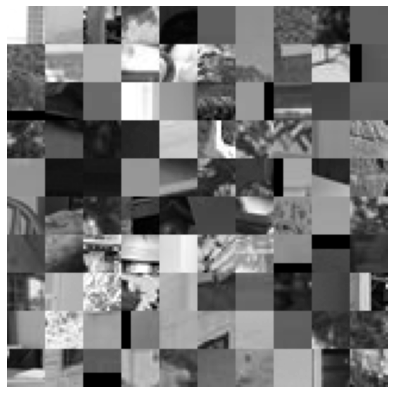

In [18]:
# Should the SIFTs be computed in another session, here's a reminder:
dir_sift = os.path.join(save_path, 'sift')
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image) 

# Choose 30 random images and get their SIFTs.
indexes = np.random.randint(0,len(inames),30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]
# Compute SIFT and regions from those 30 images.
regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) 
# Show 100 of the regions we found.
display_images(regions[np.random.choice(len(regions), 100)])
# That's our restricted dataset.

Using this dataset, we want to show a few example regions that are close (similar, SIFT-wise) to the dictionary's cluster centers.  
This should be a visual proof for us to trust our results.

In [19]:
# vdregions is a numpy array of size 1001 x 16 x 16, where each of the 1001 elements is a
# "prototype" patch that is very close to a cluster's center.
from scipy.spatial.distance import cdist
dists = cdist(vdict,sifts,metric='euclidean')
vdregions = regions[np.argmin(dists,axis=1)]
# We could show only a few of these very close neighbours as you asked us to.
# Nonetheless, we want further evidence that our clustering is satisfactory: see below. 

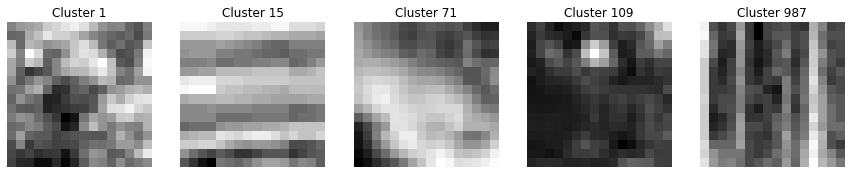

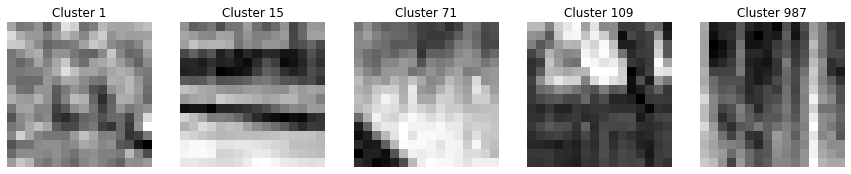

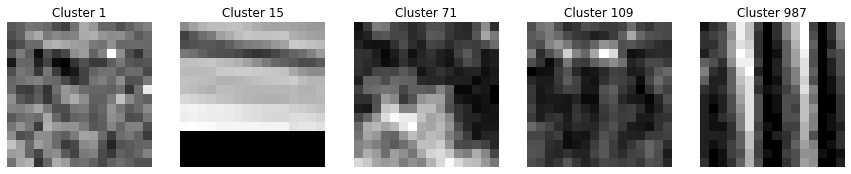

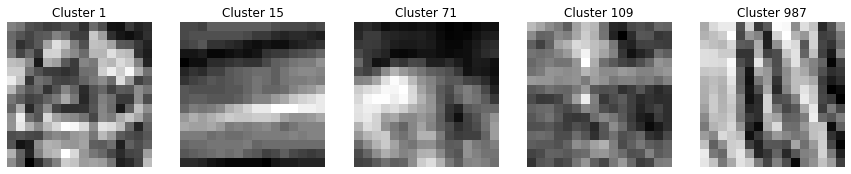

Sure, they're equal.


In [20]:
# Let's make a dictionary that also contains the 2nd, 5th and 15th closest image
# to each cluster center: each series of four should show similar features.
vdplus = regions[np.argsort(dists,axis=1)[:,[0,2,5,15]]]
for i in range(4):
    reg = plt.figure(figsize=(15,4))
    reg.add_subplot(151)
    plt.imshow(vdplus[1][i])
    plt.title("Cluster 1")
    plt.axis('off')
    reg.add_subplot(152)
    plt.imshow(vdplus[15][i])
    plt.title("Cluster 15")
    plt.axis('off')
    reg.add_subplot(153)
    plt.imshow(vdplus[71][i])
    plt.title("Cluster 71")
    plt.axis('off')
    reg.add_subplot(154)
    plt.imshow(vdplus[109][i])
    plt.title("Cluster 109")
    plt.axis('off')
    reg.add_subplot(155)
    plt.imshow(vdplus[987][i])
    plt.title("Cluster 987")
    plt.axis('off')
    plt.show()
# This is nice !

# Note that the first row below matches vdregions' contents.
if np.all(vdplus[:,0][0]==vdregions[0]):
    print("Sure, they're equal.")

It looks like the dictionary contains homogeneous clusters with easily-interpreted, distinctive features in each.

NB: talking about "dark" and "light" is not really relevant, since the SIFT descriptors are computed in a way that make them resilient to luminosity changes - through a series of filterings and normalisations. However, the global contrast remains, so our observations are easily worded this way.

## The Bag-of-Words approach

Each image can now be constrained to a bag of 2D-words (or SIFT patches). Which clusters would best describe the elements found in it?

This technique as a whole is useful to compute similarity scores. The interpretativity of the model depends on the size of the patches we keep. We used 16*16, which is globally too small to recognise objects and deploy classical, human-scaled semantics.  

Notice that all spatial information is lost: we have no information whatsoever about the way each word should be arranged with the rest. This means that the process does not work backwards - we have no way of retrieving the initial image.


In [21]:
# Build a BoW for an image.
from scipy.spatial import distance_matrix
def compute_feats(vdict,image_sifts):
    # Flattening the SIFTs.
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])
    ##################### 
    ## Votre code ici  ##
    #####################
    # Computing distance from the image SIFTs to vdict.
    dist = distance_matrix(sifts,vdict)
    for i in range(sifts.shape[0]):
        h = np.zeros((vdict.shape[0]))
        h[np.argmin(dist[i])] = 1  
        # Applying the pooling over all the SIFTs.  
        feats += h
    feats /= np.linalg.norm(feats,ord=2,keepdims=True)
    ####################
    ##      FIN        #
    ####################
    return feats

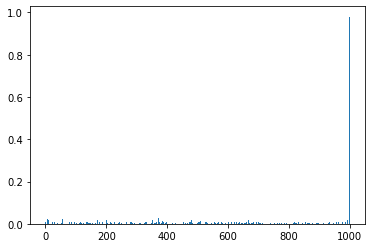

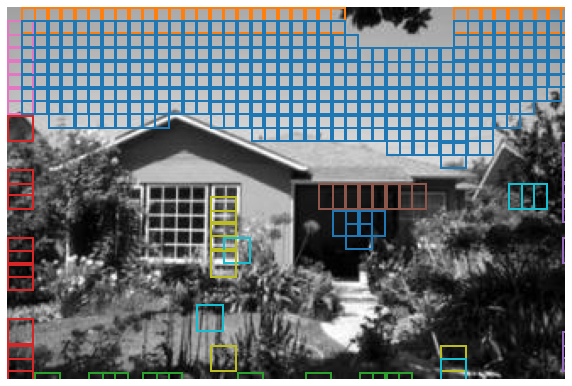

(9, 16, 16)


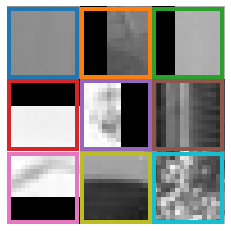

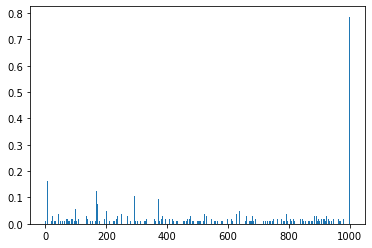

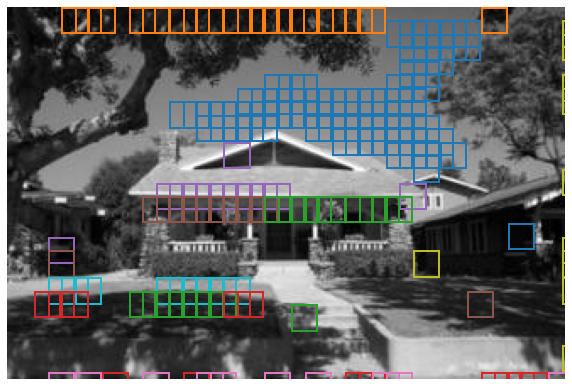

(9, 16, 16)


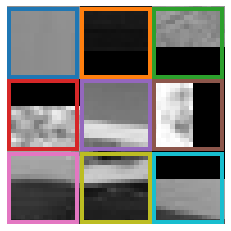

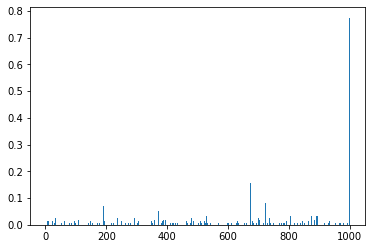

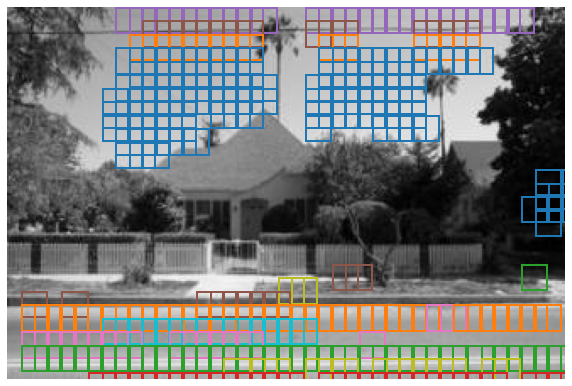

(9, 16, 16)


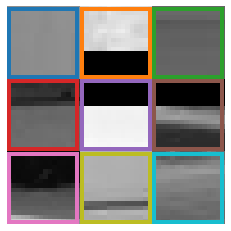

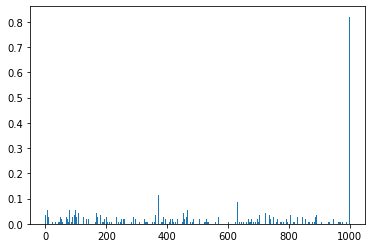

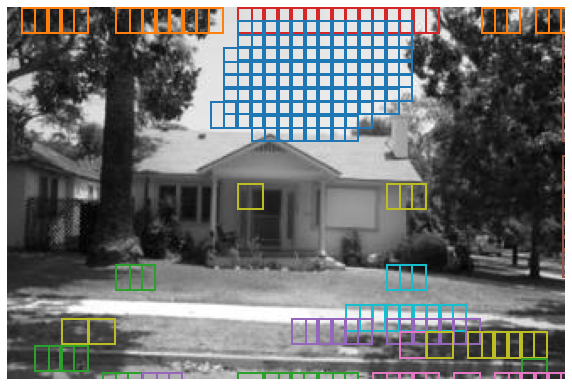

(9, 16, 16)


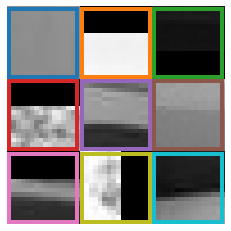

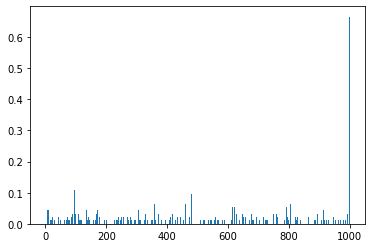

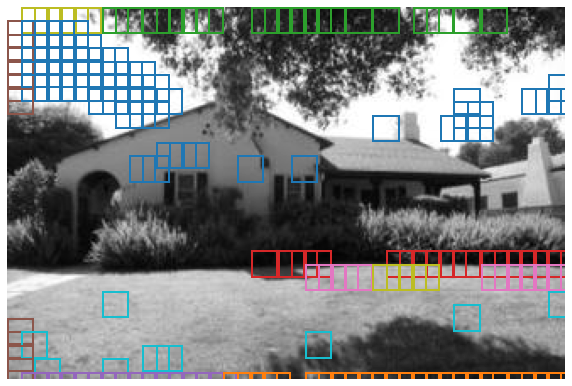

(9, 16, 16)


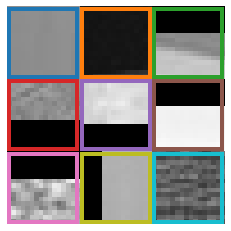

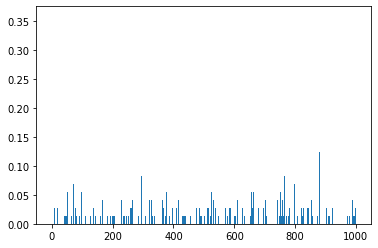

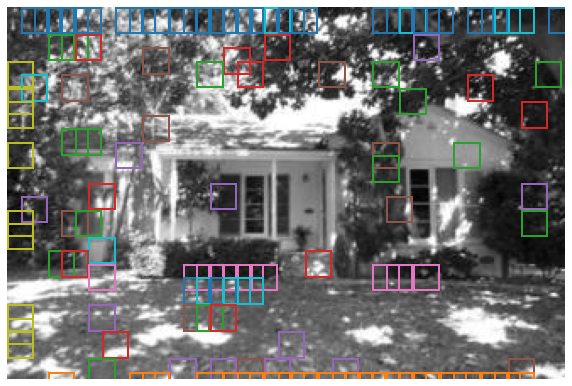

(9, 16, 16)


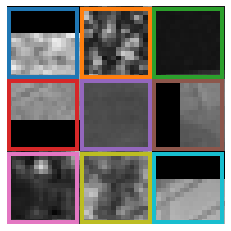

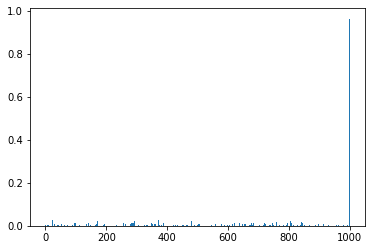

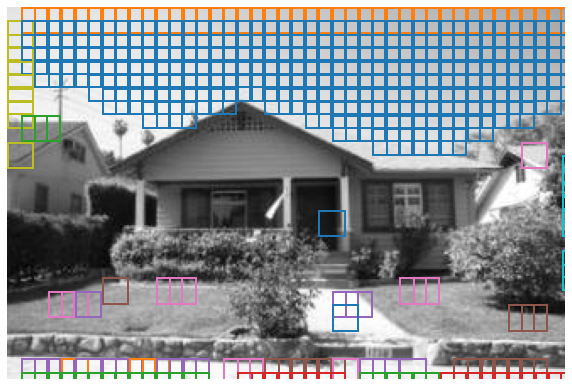

(9, 16, 16)


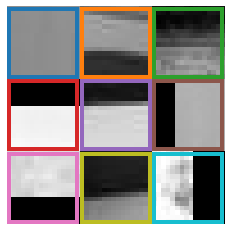

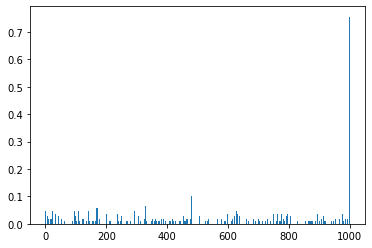

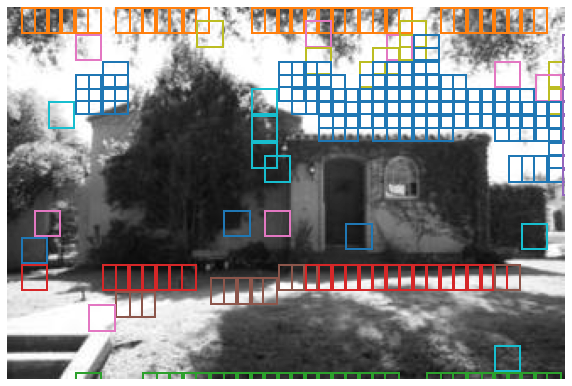

(9, 16, 16)


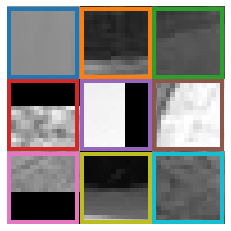

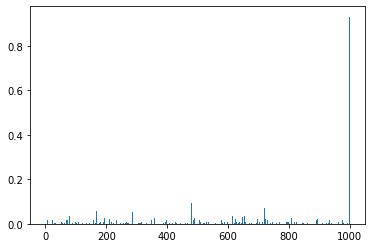

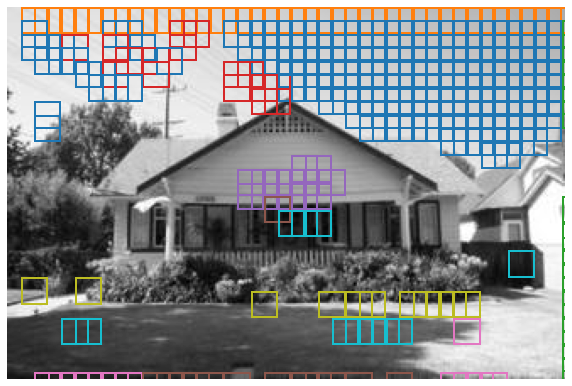

(9, 16, 16)


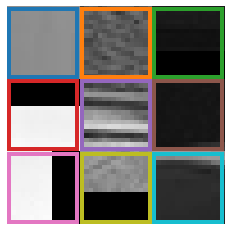

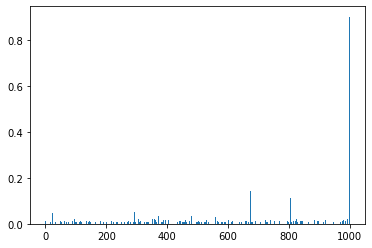

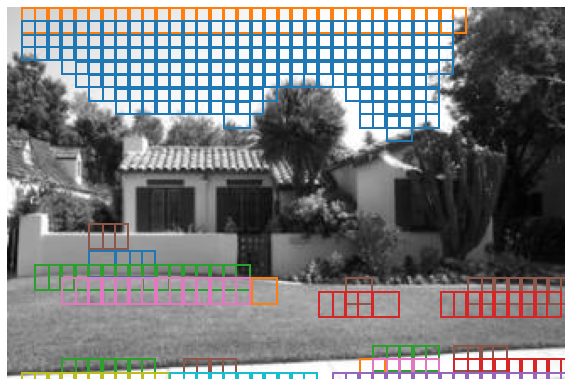

(9, 16, 16)


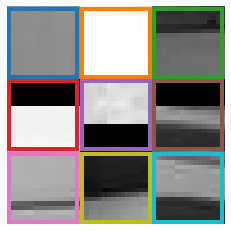

In [22]:
# Visualise the BoW for some images.
for i in range(10):
    iname = inames[i]
    ipath = os.path.join(dir_sc, iname)
    im = read_grayscale(ipath)
    sift = compute_sift_image(im)
    sift = (sift*255).astype('uint8')
    regions = compute_regions(im)
    feats = compute_feats(vdict,sift)
    display_vdregions_image(im, vdict, sift, feats, vdregions=vdregions)

We tried with a few images and this result is a bit upsetting. All the attention goes to the image borders.  
Most of the SIFT descriptors retained have a high affinity with visual words that feature thick dark bars around their limits. That's the padding !..
There is an easy solution though. It would be to apply mirroring instead of zero-filling for the padding.